# Web Scraping Indeed.com for Data Science Job Requirements in Hong Kong

This data analysis will be using Python's Scrapy framework to scrape Indeed.com for Data Science Job Requirements. Indeed does have a [REST API](https://github.com/indeedassessments/api-documentation) but at the time of this writing, the API is still under construction so I will be performing web scraping.
<img src="data/indeed-750.jpg" alt="Indeed.com" style="width: 300px;"/>
After the web scraping of web pages linked to the search term `Data Science`, I will be analyzing the job description and generating a word cloud visualization of the top skills required for Data Science roles in Hong Kong.

<img src="data/Generic_DataScienceWordCloud.jpeg" alt="Data Science Word Cloud" style="width: 500px;"/>

### Business Question: What are the main skills that a Data Scientist needs in Hong Kong?

<img src="data/Data Science Life Cycle.png" alt="Data Science Life Cycle" style="width: 500px;"/>

### Part 1: Data Mining

What is web scraping? It is extracting content from websites. First you need to study the website to know what information it has and where to get it from. Specifically, using HTML tags and CSS ids.

Why would you do it? If you don't have an API to get information you can programatically get data from a web page when no API's have been necessarily provided.

I will be using Scrapy - a complete Python framework used for automatic web crawling and scraping. This will deal with the communication aspect of the operation between the server hosting the target website and our python console.


#### First, I inspect the website and test out an X-Path selector string using Chrome Developer Tools.

<img src="data/IndeedInspect.png" alt="Data Science Life Cycle" style="width: 1500px;"/>

It seems that all the requirements and job description details are always listed in bullet points. Therefore, our xpath selector for scrapy will be: `//div/ul/li/text()` when I want to get a list of requirements and `//head/title/text()` for the title of each page. Now, I need to create the spider to crawl across all the Data Science jobs in Hong Kong.

#### This is where I crawl, across the entire search spectrum of Indeed's Data Science jobs in Hong Kong

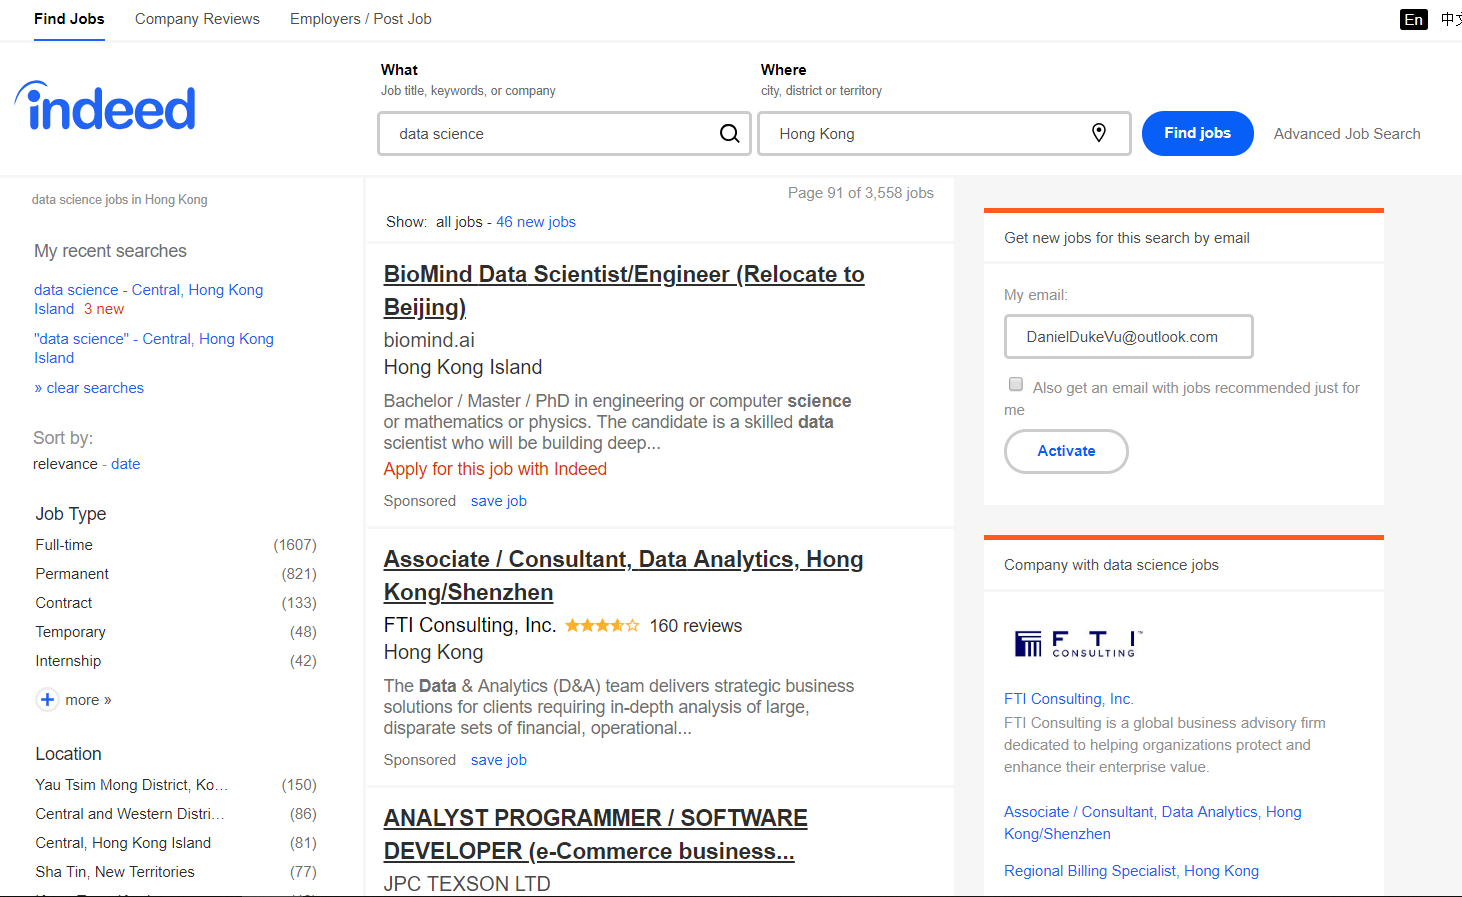


This is the code I created in my spider to crawl Indeed:

```
# -*- coding: utf-8 -*-
import scrapy
from scrapy.linkextractor import LinkExtractor
from scrapy.spiders import Rule, CrawlSpider
from indeedSpider.items import Article


class ArticleSpider(CrawlSpider):
    # The name of the spider
    name = "article"

    # The domains that are allowed (links to other domains are skipped)
    allowed_domains = ["indeed.hk"]

    # The URLs to run on. The site maxes out at page start page 990. 
    start_urls = [f"https://www.indeed.hk/jobs?q=data+science&l=Hong+Kong&start={i}" for i in range(0, 1000, 10)]

    # This spider has one rule: extract all (unique and canonicalized) links, follow them and parse them using the parse_item method
    rules = [
        Rule(
            LinkExtractor(
                canonicalize=True,
                unique=True
            ),
            follow=True,
            callback="parse_item"
        )
    ]

    #Spiders can take custom settings, these are higher priority then the setting.py - contains additional setting specific to this spider.
    custom_settings = {
        'DEPTH_LIMIT': 1, # this will only go one deep, come back, go to next link, and then come back, etc.
        'DOWNLOAD_DELAY' : 0.25
    }

    # Method which starts the requests by visiting all URLs specified in start_urls
    def start_requests(self):
        for url in self.start_urls:
            yield scrapy.Request(url, callback=self.parse, dont_filter=True)


    def parse_item(self, response):

        # creating a new instance of our Article() object that will store the data that inherits from Item parent object defined in our framework (items.py)
        item = Article() 

        # passes a response into this from our crawl, and here we get the title
        title = response.xpath('//head/title/text()').getall()
        # get the content
        content = response.xpath('//div/ul/li/text()').getall()

        # This is my flag - if more than 25% of all the characters are white space, we have a problem, dump the content:
        space_percent = str(content).count(' ') / len(str(content))
        if space_percent > .25:
            content = []
        # another flag, if the content size is less than this, it must be nothing:
        elif len(str(content)) < 30:
            content = []
        # another flag, removing terms of service link:
        elif title[0] == "Cookies, Privacy and Terms of Service | Indeed.hk":
            content = []
        
        # get the string of the first title inside the list of strings
        item['title'] = title[0]
        # passing content to our item
        item['content'] = content
        
        # Tracing
        print("Title is: ", title[0])
        print("Content is: ", content)

        # only return content if we didn't dump it
        if content:
            return item
```            

The spider has filters in place to dump articles that are not relevant. After running the spider crawl, these are the result statistics:

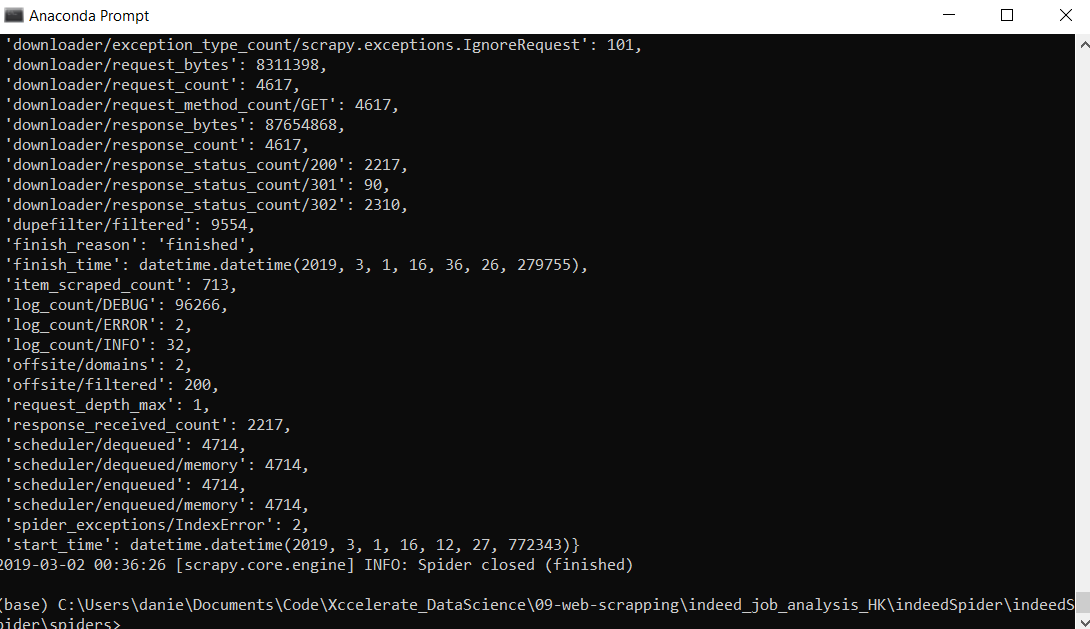

The spider crawled through 4,617 links and returned 713 job descriptions.

## Part 2 - Data Cleaning

Let's import the JSON file and start cleaning it up.

In [46]:
import json
import pandas as pd

# reading the JSON data using json.load()
with open('data/indeedscrape.json') as f:
    scrapedjson = json.load(f)

# exploring what some of our JSON data looks like:
scrapedjson[3:5]

[{'title': 'Assistant Training Executive - Hong Kong - Indeed.hk',
  'content': ['Administer the Learning Management System',
   'Be the administrator of accreditation body',
   'Provide on-site support and registration of public courses',
   'Coordinate training course arrangement, including registration, certificate issuance and post-course evaluation etc.',
   'Work location: Hong Kong Science Park',
   'Diploma holder or above with at least 2 years of working experience',
   'Previous training administration experience is preferred',
   'Computer knowledge in Chinese word processor and Windows application – MS Word, Excel',
   'Outgoing, organized and hardworking',
   'Good command of written and spoken English and Chinese',
   '5-day Work Week',
   'Double Pay and Performance Bonus',
   'Dental and Medical Benefits',
   'Life Insurance',
   'Annual Leave',
   'Paid Maternity Leave, Paternity Leave, and Marriage Leave',
   'Career Advancement Opportunities',
   'On-the-Job Training

In [48]:
# let's strip the new lines:
for i in range(len(scrapedjson)):
    scrapedjson[i]['title'] = scrapedjson[i]['title'].strip()
    for j in range(len(scrapedjson[i]['content'])):
        scrapedjson[i]['content'][j] = scrapedjson[i]['content'][j].strip()
        
# take a look:
scrapedjson[4]

{'title': 'IBM Graduate Trainee (Business and Technology Consultant) - Hong Kong - Indeed.hk',
 'content': ['Business Analyst',
  'Project Manager Assistant',
  'Change Management Consultant',
  'Business Process and Functional Consultant',
  'Digital Strategy Consultant',
  'Customer Experience Designer',
  'Cloud Application Consultant',
  'Data Scientist',
  'Oracle / SAP / SalesForce Consultant',
  'Full Stack Developer',
  'Experience Platform and Mobile Developer',
  'Blockchain Developer',
  '- How do you cope with changing demands and stress? Are you flexible? Have you successfully completed several projects with competing deadlines?',
  '- Do you present information clearly, precisely and succinctly? Adapt the way you communicate to your audience? And listen to others?',
  '- Can you see a situation from a client’s viewpoint, whether that’s colleagues or customers? Can you anticipate their needs?',
  '- Do you use ingenuity, supported by logical methods and analysis, to propos

In [59]:
# Do we any duplicate data or repeated job descriptions?
# let's put it into a dataframe then run unique on that:
import pandas as pd

df = pd.DataFrame.from_dict(scrapedjson)

df.head()

,content,title
0,"[Involve in inhouse application development, d...",Information Technology Internship (1-year prog...
1,[Assess and analyze customers’ nutritional nee...,Nutritionist /Dietitian (R0301-D) - Hong Kong ...
2,"[Perform database installation, patching, upgr...",Database Administrator - Hong Kong - Indeed.hk
3,"[Administer the Learning Management System, Be...",Assistant Training Executive - Hong Kong - Ind...
4,"[Business Analyst, Project Manager Assistant, ...",IBM Graduate Trainee (Business and Technology ...


In [65]:
print(f'There are {df.shape[0]} total job descriptions.')

print(f'There are {len(df.title.unique())} unique job descriptions.')

print(f'We have {df.shape[0] - len(df.title.unique())} duplicates that need to be removed.')

There are 713 total job descriptions.
There are 556 unique job descriptions.
We have 157 duplicates that need to be removed.


157 duplicates need removing. Let's clean up our dataframe and do this.

In [86]:
df.drop_duplicates('title', inplace = True)

print(f'We now have {df.shape[0]} total job descriptions.')

We now have 556 total job descriptions.


Now, let's reorder our dataframe so the title is first.

In [85]:
# reordering the dataframe:
cols = list(df.columns)

df = df[cols[::-1]]

df.head()

,title,content
0,Information Technology Internship (1-year prog...,"[Involve in inhouse application development, d..."
1,Nutritionist /Dietitian (R0301-D) - Hong Kong ...,[Assess and analyze customers’ nutritional nee...
2,Database Administrator - Hong Kong - Indeed.hk,"[Perform database installation, patching, upgr..."
3,Assistant Training Executive - Hong Kong - Ind...,"[Administer the Learning Management System, Be..."
4,IBM Graduate Trainee (Business and Technology ...,"[Business Analyst, Project Manager Assistant, ..."


## Data Exploration

What I am going to do is start with a huge bank of data-science related words and then see if the job description mentions this skill / requirement or not. 

The bank of words I will use are:
```
'bachelor', 'masters', 'phd', 'computer science', 'math', 'algebra', 'calculus', 'statistics', 'informatics', 'python', ' r,', ' r ', 'c+', 'c#', 'java', 'javascript', 'node', 'angular', 'html', 'php', 'bootstrap', 'django', 'css', 'wordpress', 'agile''d3.js', 'tableau', 'jupyter', 'seaborn', 'sql', 'nosql', 'mysql', 'postgres', 'mongodb', ' api', 'scala', 'hadoop', 'spark', 'tensor', 'nltk', ' ai', 'cloud', ' etl', 'azure', 'data lake', 'data model', 'hortonworks', 'pyspark', 'numpy', 'pandas', 'linux', 'unix', 'deep learning', 'neural network', 'machine learning', 'data mining', 'research', 'recommendation systems', 'scrap', 'scikit', 'keras', 'agile', 'communication', 'interpersonal', 'fresh grad', 'people skills', 'english', 'mandarin', 'cantonese'
```

In [88]:
# content visualization testing
str(df.iloc[0,1]).lower()

"['involve in inhouse application development, documentation and testing', 'provide insight and analysis on web/social applications', 'perform r&d related projects as assigned by supervisors', 'undergraduate, preferable penultimate students who are studying it programming, computer science or related disciplines', 'with basic knowledge on nodejs, javascript, web service, mysql/mongo db', 'understand facebook/wechat app development will be an advantage', 'good interpersonal and communication skill', 'a team player and is ready to take on challenges', 'an individual who is highly motivated and with keen interest to learn and explore new technology skills and business applications']"

In [91]:
# base conditional test:
'node' in str(df.iloc[0,1]).lower()

True